In [1]:
recipes_DF = spark.read.json("dbfs:/FileStore/tables/train.json", multiLine=True)

In [2]:
# INSPECT THE SIZE OF OUR DATA

def to_standard(string):
  return string.replace("_", " ").upper().encode("utf-8")

def combine_dict(this, other):
  for key, value in other.iteritems():
    if this.has_key(key):
      this[key] += other[key]
    else:
      this[key] = other[key]
      
  return this

n_recipes_by_cuisine_RDD = (recipes_DF.rdd
                            .map(lambda r : (to_standard(r["cuisine"]), 1))
                            .reduceByKey(lambda a, b : a + b)
                            .cache())

n_ingredients_by_cuisine_RDD = (recipes_DF.rdd
                                .map(lambda r : (to_standard(r["cuisine"]), {to_standard(i): 1 for i in r["ingredients"]}))
                                .reduceByKey(lambda a, b : combine_dict(a, b))
                                .map(lambda (c, r) : (c, len(r)))
                                .cache())

n_occurences_per_ingredient_RDD = (recipes_DF.rdd
                                   .flatMap(lambda r : r["ingredients"])
                                   .map(lambda i : (to_standard(i), 1))
                                   .reduceByKey(lambda a, b : a + b)
                                   .cache())

avg_ingredients_by_cuisine_RDD = (recipes_DF.rdd
                                  .map(lambda r : (to_standard(r["cuisine"]), (len(r["ingredients"]), 1)))
                                  .reduceByKey(lambda a, b : (a[0] + b[0], a[1] + b[1]))
                                  .map(lambda (c, t) : (c, float(t[0]) / t[1]))
                                  .cache())

print "No. of Recipes: %s" % recipes_DF.rdd.count()
print "No. of Cuisines: %s" % n_recipes_by_cuisine_RDD.count()
print "No. of Ingredients: %s" % n_occurences_per_ingredient_RDD.count()

No. of Recipes: 39774
No. of Cuisines: 20
No. of Ingredients: 6703

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set()

BAR_WIDTH = 0.8
LABEL_SIZE = 7

def plot_bar_chart(data, color='b'):
  index = np.arange(len(data))
  fig, ax = plt.subplots()
  
  plt.subplot(1, 1, 1)
  plt.bar(index, [tuple[1] for tuple in data], BAR_WIDTH, color=color)
  plt.xticks(index + BAR_WIDTH / 2, [tuple[0].replace(" ", "\n") for tuple in data], rotation="vertical")
  plt.tick_params(labelsize=LABEL_SIZE)
  
  display(fig)

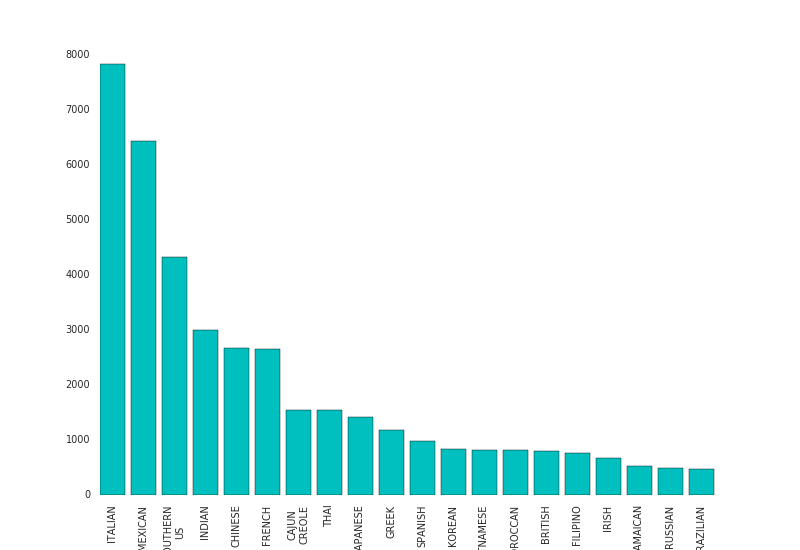

In [4]:
# CHART OF THE NO. OF RECIPES PER CUISINE

plot_bar_chart(n_recipes_by_cuisine_RDD.takeOrdered(20, lambda (c, sum) : -1 * sum), color='c')

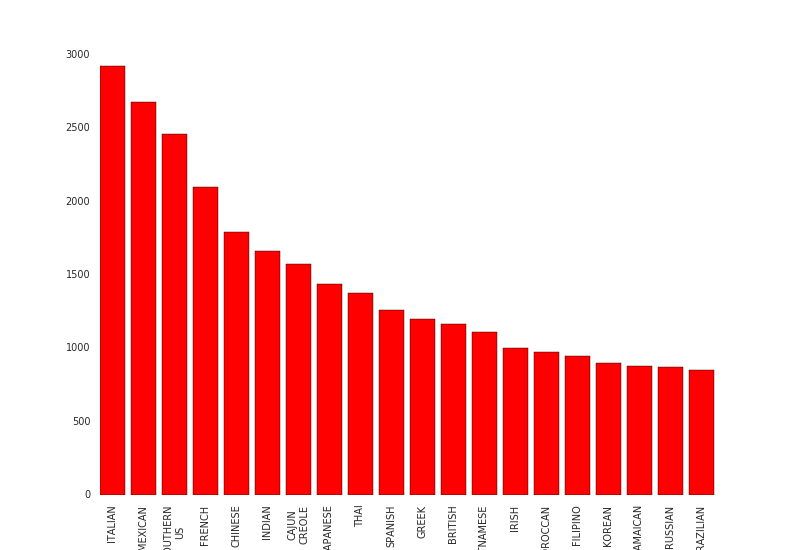

In [5]:
# CHART OF NO. OF UNIQUE INGREDIENTS BY CUISINE

plot_bar_chart(n_ingredients_by_cuisine_RDD.takeOrdered(20, lambda (c, sum) : -1 * sum), color='r')

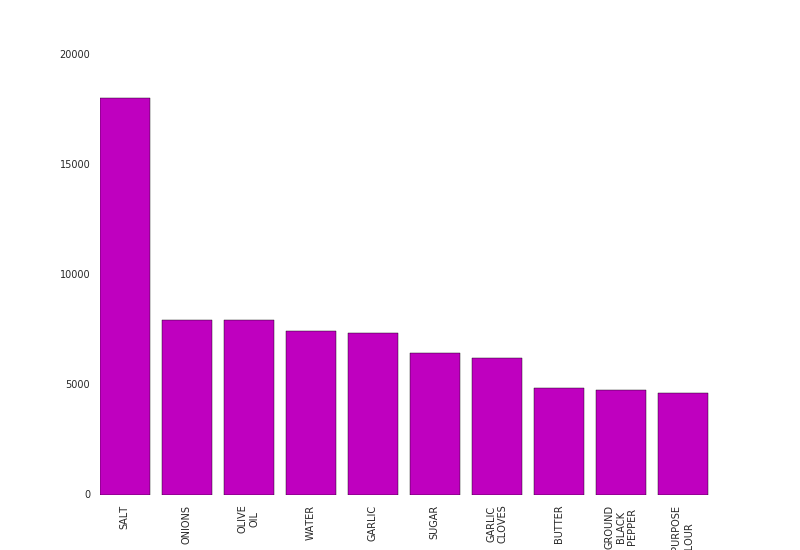

In [6]:
# CHART OF THE FREQUENCY OF OCCURENCE OF EACH INGREDIENT ACROSS ALL RECIPES

plot_bar_chart(n_occurences_per_ingredient_RDD.takeOrdered(10, lambda (i, sum) : -1 * sum), color='m')

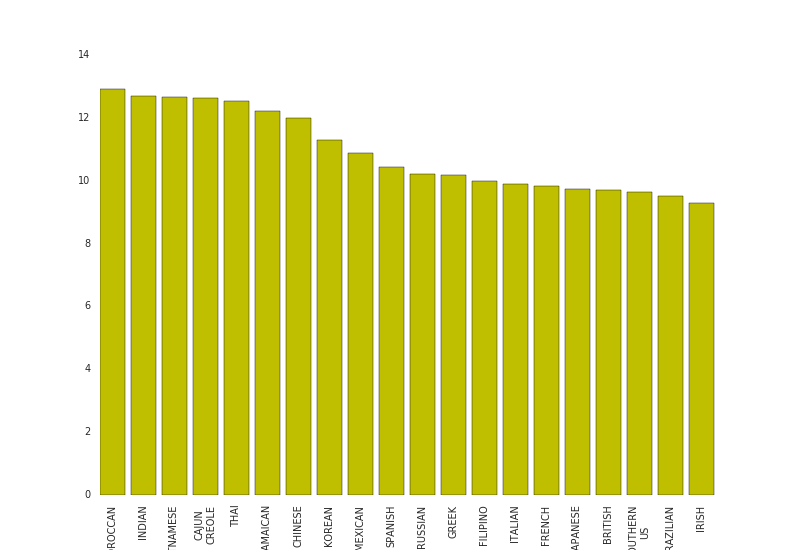

In [7]:
# CHART OF THE AVERAGE NO. OF INGREDIENTS USED PER RECIPE, BY CUISINE

plot_bar_chart(avg_ingredients_by_cuisine_RDD.takeOrdered(20, lambda (c, avg) : -1 * avg), color='y')

In [8]:
from pyspark.ml.feature import Word2Vec

all_ingredients_RDD = (n_occurences_per_ingredient_RDD
                       .map(lambda (i, sum) : (i.split(" "), )))

all_ingredients_DF = spark.createDataFrame(all_ingredients_RDD.collect(), ["text"])

word2Vec = Word2Vec(vectorSize=50, minCount=0, inputCol="text", outputCol="result")
model = word2Vec.fit(all_ingredients_DF)

results = {" ".join(text): vector for text, vector in model.transform(all_ingredients_DF).collect()}

In [9]:
def check_similarity(a, b):
  x = results.get(a)
  y = results.get(b)
  
  if x == None or y == None:
    return -1
  else:
    return x.dot(y) / (x.norm(2) * y.norm(2))

N = 10
M = 3

to_compare_RDD = (n_occurences_per_ingredient_RDD
                  .sortBy(lambda (i, sum) : 1 * sum))

to_compare = [t[0] for t in to_compare_RDD.take(N)]

output = []
for ingredient in to_compare:
  cosine_similarities_RDD = (n_occurences_per_ingredient_RDD
                             .map(lambda (i, sum) : i)
                             .map(lambda i : (i, check_similarity(ingredient, i))))
  
  most_similar = cosine_similarities_RDD.takeOrdered(M + 1, lambda (i, similarity) : -1 * similarity)
  
  string = "%s -" % ingredient
  for i, similarity in most_similar:
    if not i == ingredient:
      string += "\n\t%s: %s" % (i, round(similarity, 3))
  
  output.append(string)

print "\n\n".join(output)

TOPSIDE STEAK -
	STEAK: 0.824
	CALAMARI STEAK: 0.749
	RUMP STEAK: 0.705

ICING MIX -
	SOUR MIX: 0.857
	STUFFING MIX: 0.827
	CAKE MIX: 0.817

KRAFT ORIGINAL BARBECUE SAUCE -
	BARBECUE SAUCE: 0.928
	HOISIN SAUCE: 0.915
	ASIAN BARBECUE SAUCE: 0.914

SKINLESS CHICKEN BREAST FILLETS -
	SKINLESS CHICKEN FILLETS: 0.992
	CHICKEN BREAST FILLETS: 0.989
	BONELESS CHICKEN BREAST: 0.987

BONED SKINNED DUCK BREAST HALVES -
	SKINNED BONED DUCK BREAST HALVES: 1.0
	BONED DUCK BREAST HALVES: 0.987
	DUCK BREAST HALVES: 0.975

CAKE MIX OR WHITE YELLOW -
	WHITE CAKE MIX: 0.931
	MARTHA WHITE CORNBREAD MIX: 0.847
	JAMBALAYA RICE MIX: 0.837

CHAI TEA CONCENTRATE -
	FRESH OREGANO: 0.84
	FROZEN LEMONADE CONCENTRATE: 0.836
	SWEET TEA: 0.814

ESSENCE SEASONING -
	SEASONING: 0.823
	BLACKENING SEASONING: 0.783
	SOUTHWEST SEASONING: 0.75

PINEAPPLE CHUNKS IN NATURAL JUICE -
	FRESH LEMON JUICE: 0.932
	CRUSHED PINEAPPLES IN JUICE: 0.93
	TUNA IN OIL: 0.918

CASTELVETRANO OLIVES -
	OLIVES: 0.814
	GREEN OLIVES: 0.72
	SLICED GREEN OLIVES: 0.695

In [10]:
# INITIALIZE CONFUSION MATRIX AND OTHER USEFUL VARIABLES

all_cuisines = avg_ingredients_by_cuisine_RDD.map(lambda (c, avg) : c).collect()

confusion_matrix = {c: {c: 0 for c in all_cuisines} for c in all_cuisines}

total_accuracy = 0
total_in_top_3 = 0

n_runs = 0

In [11]:
# SEPARATE DATA INTO TRAINING AND TEST SETS

WEIGHTS = [0.99, 0.01]

train_recipes_RDD, test_recipes_RDD = (recipes_DF.rdd
                                       .randomSplit(WEIGHTS))

train_recipes_RDD = (train_recipes_RDD
                     .map(lambda r : (to_standard(r["cuisine"]), {to_standard(i): 1 for i in r["ingredients"]}))
                     .cache())

test_recipes_RDD = (test_recipes_RDD
                    .map(lambda r : (to_standard(r["cuisine"]), [to_standard(i) for i in r["ingredients"]]))
                    .cache())

print "No. of Samples in Training Set: %s" % train_recipes_RDD.count()
print "No. of Samples in Test Set: %s" % test_recipes_RDD.count()

No. of Samples in Training Set: 39383
No. of Samples in Test Set: 391

In [12]:
# CALCULATE NORMALIZED RELATIVE FREQUENCIES PER INGREDIENT, BY CUISINE

aggregated_ingredients_RDD = (train_recipes_RDD
                             .reduceByKey(lambda a, b : combine_dict(a, b))
                             .cache())

normalized_frequencies_RDD = (aggregated_ingredients_RDD
                              .map(lambda (c, i) : (c, {k: len(i) * float(v) / sum(i.values()) for k, v in i.iteritems()}))
                              .cache())

In [13]:
# TAKE A LOOK AT THE VALUES (SANITY CHECK)

ORDER = -1

def sort_by_value(dict):
  sorted_keys = sorted(dict, key=lambda x : ORDER * dict[x])
  output = []
  
  for key in sorted_keys:
      output.append((key, dict[key]))
      
  return output

sorted_aggregated_ingredients_RDD = (aggregated_ingredients_RDD
                                     .map(lambda (c, i) : (c, sort_by_value(i))))

sorted_normalized_frequencies_RDD = (normalized_frequencies_RDD
                                     .map(lambda (c, i) : (c, sort_by_value(i))))

def display_frequencies(dict, n=5):
  output = []
  for cuisine, ingredients in dict:
    string = "%s -" % cuisine
    for i in range(n):
      string += "\n\t%s: %s" % (ingredients[i][0], ingredients[i][1])     
    output.append(string)
    
  print "\n\n".join(output)

n = 5

print "RAW FREQUENCIES (TOP %s INGREDIENTS)" % n
print "-----------------------------------"
display_frequencies(sorted_aggregated_ingredients_RDD.collect(), n)

print ""

print "NORMALIZED RELATIVE FREQUENCIES (TOP %s INGREDIENTS)" %n
print "---------------------------------------------------"
display_frequencies(sorted_normalized_frequencies_RDD.collect(), n)

RAW FREQUENCIES (TOP 5 INGREDIENTS)
-----------------------------------
IRISH -
	SALT: 372
	ALL-PURPOSE FLOUR: 217
	BUTTER: 216
	ONIONS: 132
	POTATOES: 119

MEXICAN -
	SALT: 2700
	ONIONS: 1477
	GROUND CUMIN: 1337
	GARLIC: 1303
	OLIVE OIL: 1278

CHINESE -
	SOY SAUCE: 1345
	SESAME OIL: 903
	SALT: 897
	CORN STARCH: 894
	SUGAR: 813

FILIPINO -
	SALT: 417
	GARLIC: 320
	WATER: 306
	ONIONS: 306
	SOY SAUCE: 246

VIETNAMESE -
	FISH SAUCE: 389
	SUGAR: 343
	SALT: 263
	GARLIC: 238
	WATER: 227

SPANISH -
	SALT: 456
	OLIVE OIL: 385
	GARLIC CLOVES: 287
	EXTRA-VIRGIN OLIVE OIL: 253
	ONIONS: 252

SOUTHERN US -
	SALT: 2257
	BUTTER: 1238
	ALL-PURPOSE FLOUR: 1207
	SUGAR: 1042
	LARGE EGGS: 734

JAPANESE -
	SOY SAUCE: 557
	SALT: 417
	MIRIN: 399
	SUGAR: 397
	WATER: 379

MOROCCAN -
	SALT: 404
	OLIVE OIL: 403
	GROUND CUMIN: 342
	ONIONS: 273
	GARLIC CLOVES: 219

GREEK -
	SALT: 566
	OLIVE OIL: 500
	DRIED OREGANO: 264
	GARLIC CLOVES: 252
	FETA CHEESE CRUMBLES: 252

INDIAN -
	SALT: 1911
	ONIONS: 1187
	GARAM MASALA: 849
	WATER: 807
	GROUND TURMERIC: 720

JAMAICAN -
	SALT: 328
	ONIONS: 171
	WATER: 149
	GARLIC: 138
	GROUND ALLSPICE: 126

BRITISH -
	SALT: 404
	ALL-PURPOSE FLOUR: 236
	BUTTER: 221
	MILK: 201
	EGGS: 191

BRAZILIAN -
	SALT: 193
	ONIONS: 133
	OLIVE OIL: 118
	LIME: 88
	WATER: 87

RUSSIAN -
	SALT: 286
	SUGAR: 155
	ONIONS: 143
	ALL-PURPOSE FLOUR: 123
	SOUR CREAM: 114

THAI -
	FISH SAUCE: 619
	GARLIC: 410
	SALT: 387
	COCONUT MILK: 352
	VEGETABLE OIL: 332

ITALIAN -
	SALT: 3418
	OLIVE OIL: 3081
	GARLIC CLOVES: 1602
	GRATED PARMESAN CHEESE: 1569
	GARLIC: 1458

KOREAN -
	SOY SAUCE: 422
	SESAME OIL: 401
	GARLIC: 300
	GREEN ONIONS: 289
	SUGAR: 264

FRENCH -
	SALT: 1192
	SUGAR: 633
	UNSALTED BUTTER: 590
	ALL-PURPOSE FLOUR: 588
	OLIVE OIL: 515

CAJUN CREOLE -
	SALT: 738
	ONIONS: 525
	GARLIC: 364
	GREEN BELL PEPPER: 336
	BUTTER: 331

NORMALIZED RELATIVE FREQUENCIES (TOP 5 INGREDIENTS)
---------------------------------------------------
IRISH -
	SALT: 60.2129946263
	ALL-PURPOSE FLOUR: 35.1242468653
	BUTTER: 34.9623839766
	ONIONS: 21.365901319
	POTATOES: 19.2616837649

MEXICAN -
	SALT: 104.172676398
	ONIONS: 56.9863122368
	GROUND CUMIN: 51.5847660532
	GARLIC: 50.27296198
	OLIVE OIL: 49.3084001615

CHINESE -
	SOY SAUCE: 75.7710546282
	SESAME OIL: 50.8708270106
	SALT: 50.532814871
	CORN STARCH: 50.3638088012
	SUGAR: 45.8006449165

FILIPINO -
	SALT: 52.6895306859
	GARLIC: 40.4332129964
	WATER: 38.6642599278
	ONIONS: 38.6642599278
	SOY SAUCE: 31.083032491

VIETNAMESE -
	FISH SAUCE: 41.4483622351
	SUGAR: 36.5470134875
	SALT: 28.0229287091
	GARLIC: 25.3591522158
	WATER: 24.1870905588

SPANISH -
	SALT: 56.0936494001
	OLIVE OIL: 47.3597697786
	GARLIC CLOVES: 35.3045556531
	EXTRA-VIRGIN OLIVE OIL: 31.1221344259
	ONIONS: 30.9991220369

SOUTHERN US -
	SALT: 134.202672443
	BUTTER: 73.6122766879
	ALL-PURPOSE FLOUR: 71.7689967385
	SUGAR: 61.9579905564
	LARGE EGGS: 43.6441123497

JAPANESE -
	SOY SAUCE: 58.2661466686
	SALT: 43.6211546873
	MIRIN: 41.7382271468
	SUGAR: 41.5290129757
	WATER: 39.6460854352

MOROCCAN -
	SALT: 37.4741486811
	OLIVE OIL: 37.3813908873
	GROUND CUMIN: 31.7231654676
	ONIONS: 25.3228776978
	GARLIC CLOVES: 20.3139568345

GREEK -
	SALT: 56.962270507
	OLIVE OIL: 50.3200269496
	DRIED OREGANO: 26.5689742294
	GARLIC CLOVES: 25.3612935826
	FETA CHEESE CRUMBLES: 25.3612935826

INDIAN -
	SALT: 83.9983308163
	ONIONS: 52.1747873778
	GARAM MASALA: 37.3179397504
	WATER: 35.4718225896
	GROUND TURMERIC: 31.6477227565

JAMAICAN -
	SALT: 45.1860501815
	ONIONS: 23.5573615275
	WATER: 20.526589869
	GARLIC: 19.0112040398
	GROUND ALLSPICE: 17.3580558624

BRITISH -
	SALT: 60.6521963824
	ALL-PURPOSE FLOUR: 35.4304909561
	BUTTER: 33.1785529716
	MILK: 30.1759689922
	EGGS: 28.6746770026

BRAZILIAN -
	SALT: 37.1287776274
	ONIONS: 25.5861524583
	OLIVE OIL: 22.700496166
	LIME: 16.9291835814
	WATER: 16.7368064953

RUSSIAN -
	SALT: 50.205811138
	SUGAR: 27.2094430993
	ONIONS: 25.102905569
	ALL-PURPOSE FLOUR: 21.5920096852
	SOUR CREAM: 20.0121065375

THAI -
	FISH SAUCE: 44.4413583482
	GAR

In [14]:
# 'FORWARD PROPAGATE' SINGLE-LAYER NETWORK AND CALCULATE ACCURACY

def calculate_class_value(frequencies, ingredients):
  sum = 0
  for i in ingredients:
    if i in frequencies:
      print i
      sum += frequencies[i]
  
  return sum

all_cuisines = normalized_frequencies_RDD.map(lambda (c, i) : c).collect()

sum_correct = 0
sum_in_top_3 = 0

# i = 0

for cuisine, recipe in test_recipes_RDD.collect():
  output_RDD = (normalized_frequencies_RDD
                .map(lambda (c, i) : (c, calculate_class_value(i, recipe)))
                .cache())
  
  predictions = [c for c, value in output_RDD.takeOrdered(3, lambda (c, value) : -1 * value)]
  
  if cuisine == predictions[0]:
    sum_correct += 1
    
  if cuisine in predictions:
    sum_in_top_3 += 1
  
  '''
  if i % 50 == 0:
    print "INGREDIENTS: %s" % ", ".join(recipe)
    print "TOP 3 PREDICTIONS: %s" % ", ".join([c for c in predictions])
    print "ACTUAL: %s" % cuisine
    print ""
  '''
  
  confusion_matrix[predictions[0]][cuisine] += 1
  
  # i += 1
  
l = test_recipes_RDD.count()

n_runs += 1

total_accuracy += float(sum_correct) / l
total_in_top_3 += float(sum_in_top_3) / l

print "RUN ACCURACY: %s" % round(float(sum_correct) / l, 3)
print "RUN IN TOP 3: %s" % round(float(sum_in_top_3) / l, 3)

RUN ACCURACY: 0.512
RUN IN TOP 3: 0.739

In [15]:
# DISPLAY CONFUSION MATRIX

import pandas as pd

confusion_matrix_DF = pd.DataFrame(confusion_matrix).transpose()

print "NO. OF RUNS : %s" % n_runs
print "AVG ACCURACY: %s" % round(total_accuracy / n_runs, 3)
print "AVG IN TOP 3: %s" % round(total_in_top_3 / n_runs, 3)

print ""

print "CONFUSION MATRIX"
print "----------------"
print confusion_matrix_DF

NO. OF RUNS : 5
AVG ACCURACY: 0.493
AVG IN TOP 3: 0.731

CONFUSION MATRIX
----------------
 BRAZILIAN BRITISH CAJUN CREOLE CHINESE FILIPINO FRENCH \
BRAZILIAN 0 0 0 0 0 1 
BRITISH 0 1 0 0 0 0 
CAJUN CREOLE 0 0 6 0 0 0 
CHINESE 0 1 1 118 7 2 
FILIPINO 0 0 0 0 0 0 
FRENCH 0 1 0 0 0 10 
GREEK 0 0 0 0 0 1 
INDIAN 0 0 0 1 1 0 
IRISH 0 0 0 0 0 0 
ITALIAN 7 5 47 8 13 48 
JAMAICAN 0 0 0 0 0 0 
JAPANESE 0 0 0 0 0 0 
KOREAN 0 0 0 0 0 0 
MEXICAN 3 0 10 6 4 2 
MOROCCAN 0 0 0 0 0 0 
RUSSIAN 0 0 0 0 0 0 
SOUTHERN US 4 29 27 19 8 59 
SPANISH 0 1 0 0 0 0 
THAI 0 0 0 0 0 0 
VIETNAMESE 0 0 0 0 0 0 

 GREEK INDIAN IRISH ITALIAN JAMAICAN JAPANESE KOREAN \
BRAZILIAN 0 0 0 2 0 0 0 
BRITISH 0 0 0 0 0 0 0 
CAJUN CREOLE 0 0 0 0 0 0 0 
CHINESE 1 0 1 2 1 17 29 
FILIPINO 0 0 0 0 0 0 0 
FRENCH 0 0 2 7 0 1 0 
GREEK 4 0 0 0 0 0 0 
INDIAN 0 55 1 1 0 1 0 
IRISH 0 0 0 0 0 0 0 
ITALIAN 55 37 5 303 6 5 4 
JAMAICAN 0 0 0 0 0 0 0 
JAPANESE 0 0 0 0 0 18 0 
KOREAN 0 0 0 0 0 0 0 
MEXICAN 2 29 0 9 5 0 1 
MOROCCAN 0 0 0 0 0 0 0 
RUSSIAN 0 0 0 0 0 0 0 
SOUTHERN US 8 32 21 66 6 17 4 
SPANISH 0 0 0 0 0 0 0 
THAI 0 0 0 0 0 1 0 
VIETNAMESE 0 0 0 0 0 0 0 

 MEXICAN MOROCCAN RUSSIAN SOUTHERN US SPANISH THAI \
BRAZILIAN 0 0 0 0 0 0 
BRITISH 0 0 0 0 0 0 
CAJUN CREOLE 0 0 0 2 0 0 
CHINESE 0 0 0 2 2 19 
FILIPINO 0 0 0 0 0 0 
FRENCH 1 0 1 1 3 0 
GREEK 0 0 0 1 0 0 
INDIAN 0 0 1 1 0 2 
IRISH 0 0 0 0 0 0 
ITALIAN 39 25 7 47 29 12 
JAMAICAN 0 0 0 0 0 1 
JAPANESE 0 0 0 0 0 0 
KOREAN 0 0 0 0 0 0 
MEXICAN 263 9 0 5 2 11 
MOROCCAN 2 0 0 0 0 0 
RUSSIAN 0 0 0 0 0 0 
SOUTHERN US 19 7 8 174 11 14 
SPANISH 0 0 0 0 0 0 
THAI 0 0 0 0 0 32 
VIETNAMESE 0 0 0 0 0 0 

 VIETNAMESE 
BRAZILIAN 0 
BRITISH 0 
CAJUN CREOLE 0 
CHINESE 12 
FILIPINO 0 
FRENCH 0 
GREEK 0 
INDIAN 2 
IRISH 0 
ITALIAN 10 
JAMAICAN 0 
JAPANESE 0 
KOREAN 0 
MEXICAN 6 
MOROCCAN 0 
RUSSIAN 0 
SOUTHERN US 3 
SPANISH 0 
THAI 3 
VIETNAMESE 6